In [246]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import mass_mobil_functions as mmf

import joblib

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score




### <a name="top3"></a> Classification Model: Predicting State Response to a Protest


### Project Contents:
|Name|Description|
|---|---|
|1_EDA_Cleaning|Cleans and merges data from 3 sources. Initial EDA.|
|2_Time_Series_Exploration|Explores some data by country along a time series, and the potential for time series modeling.|
|3_Classification Model|Builds various classification models.|
|4_Visualizations|A visual exploration of the data.|
|data|folder containing csv files of data used|
|streamlit|folder containing streamlit.py file, folder with streamlit images, folder with streamlit data files|


You are currently in notebook 3_Classification_Model. 

#### Notebook summary: 

After exploring the data, I decided to start by building a classification model to predict state response to a protest. 

Target: State Response
Features: Details about the protest, World Governance Indices, Freedom House rating.


#### Notebook Table of Contents

* [Null Hypothesis](#null)
* [Multiclass Classification](#multi)
* [Binary Classification](#binary)


In [204]:
#reading in the data from the cleaned csv exported at the end of Notebook 1. 
m_df = pd.read_csv('../data/transformed/mm_wgi_fiw.csv')

In [205]:
m_df.dtypes

country_name                    object
ccode                            int64
year                             int64
region                          object
protest                          int64
protestnumber                    int64
protesterviolence                int64
participants_category            int64
stateresponse1                  object
start_date                      object
end_date                        object
duration                        object
duration_int                     int64
labor wage dispute               int64
land farm issue                  int64
police brutality                 int64
political behavior, process      int64
price increases, tax policy      int64
removal of politician            int64
social restrictions              int64
CC.EST                         float64
GE.EST                         float64
PV.NO.SRC                      float64
RL.EST                         float64
VA.EST                         float64
fiw_status               

In [206]:
m_df.isna().sum()

country_name                   0
ccode                          0
year                           0
region                         0
protest                        0
protestnumber                  0
protesterviolence              0
participants_category          0
stateresponse1                 0
start_date                     0
end_date                       0
duration                       0
duration_int                   0
labor wage dispute             0
land farm issue                0
police brutality               0
political behavior, process    0
price increases, tax policy    0
removal of politician          0
social restrictions            0
CC.EST                         0
GE.EST                         0
PV.NO.SRC                      0
RL.EST                         0
VA.EST                         0
fiw_status                     0
dtype: int64

In [207]:
m_df.shape

(8338, 26)

## <a name="multi"></a> Multiclass Classification Model: Predicting Primary State Response

### Purpose

The purpose of this model will be to take in features of a protest and world governance indicators of a country in order to predict how a state is most likely to respond to a given protest.

[Jump to the top of the page](#top3)



### <a name="null"></a>  Null Hypothesis

My null model will predict the state response correctly in 53% of cases

In [208]:
m_df['stateresponse1'].value_counts(normalize=True)

ignore             0.533101
crowd dispersal    0.283641
arrests            0.068602
accomodation       0.059846
shootings          0.027824
killings           0.013792
beatings           0.011753
unknown            0.001439
Name: stateresponse1, dtype: float64

In [209]:
m_df.head(3)

,country_name,ccode,year,region,protest,protestnumber,protesterviolence,participants_category,stateresponse1,start_date,...,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,CC.EST,GE.EST,PV.NO.SRC,RL.EST,VA.EST,fiw_status
0,Canada,20,2006,North America,1,1,1,3,crowd dispersal,2006-02-21,...,1,0,0,0,1.962554,1.895545,8.0,1.814535,1.415595,F
1,Canada,20,2007,North America,1,1,0,5,ignore,2007-06-29,...,1,0,0,0,2.000900,1.761394,8.0,1.814706,1.384672,F
2,Canada,20,2008,North America,1,1,1,3,crowd dispersal,2008-08-10,...,0,0,0,0,2.002689,1.791681,8.0,1.808290,1.407529,F


In [210]:
#encoding columns using custom function from mm module.

m_df = mm.categorical_to_encode(m_df, ['stateresponse1'], ['region', 'fiw_status'])
m_df.head(3)

,country_name,ccode,year,protest,protestnumber,protesterviolence,participants_category,stateresponse1,start_date,end_date,...,VA.EST,Asia,Central America,Europe,MENA,North America,Oceania,South America,NF,PF
0,Canada,20,2006,1,1,1,3,3,2006-02-21,2006-08-17,...,1.415595,0,0,0,0,1,0,0,0,0
1,Canada,20,2007,1,1,0,5,4,2007-06-29,2007-06-29,...,1.384672,0,0,0,0,1,0,0,0,0
2,Canada,20,2008,1,1,1,3,3,2008-08-10,2008-08-10,...,1.407529,0,0,0,0,1,0,0,0,0


### Checking For Correlation: Heatmap

There appear to be few strong correlations in this dataset, aside from relationships between the World Governance Indicators. I had expected to see stronger correlations, and expect building an effective model to be challenging with my given dataset. Over time I will hope to pull in more metrics. 

This heatmap does show that the Europe region in general has higher World Governance Indicator scores all round, while MENA appears to have the lowest. 

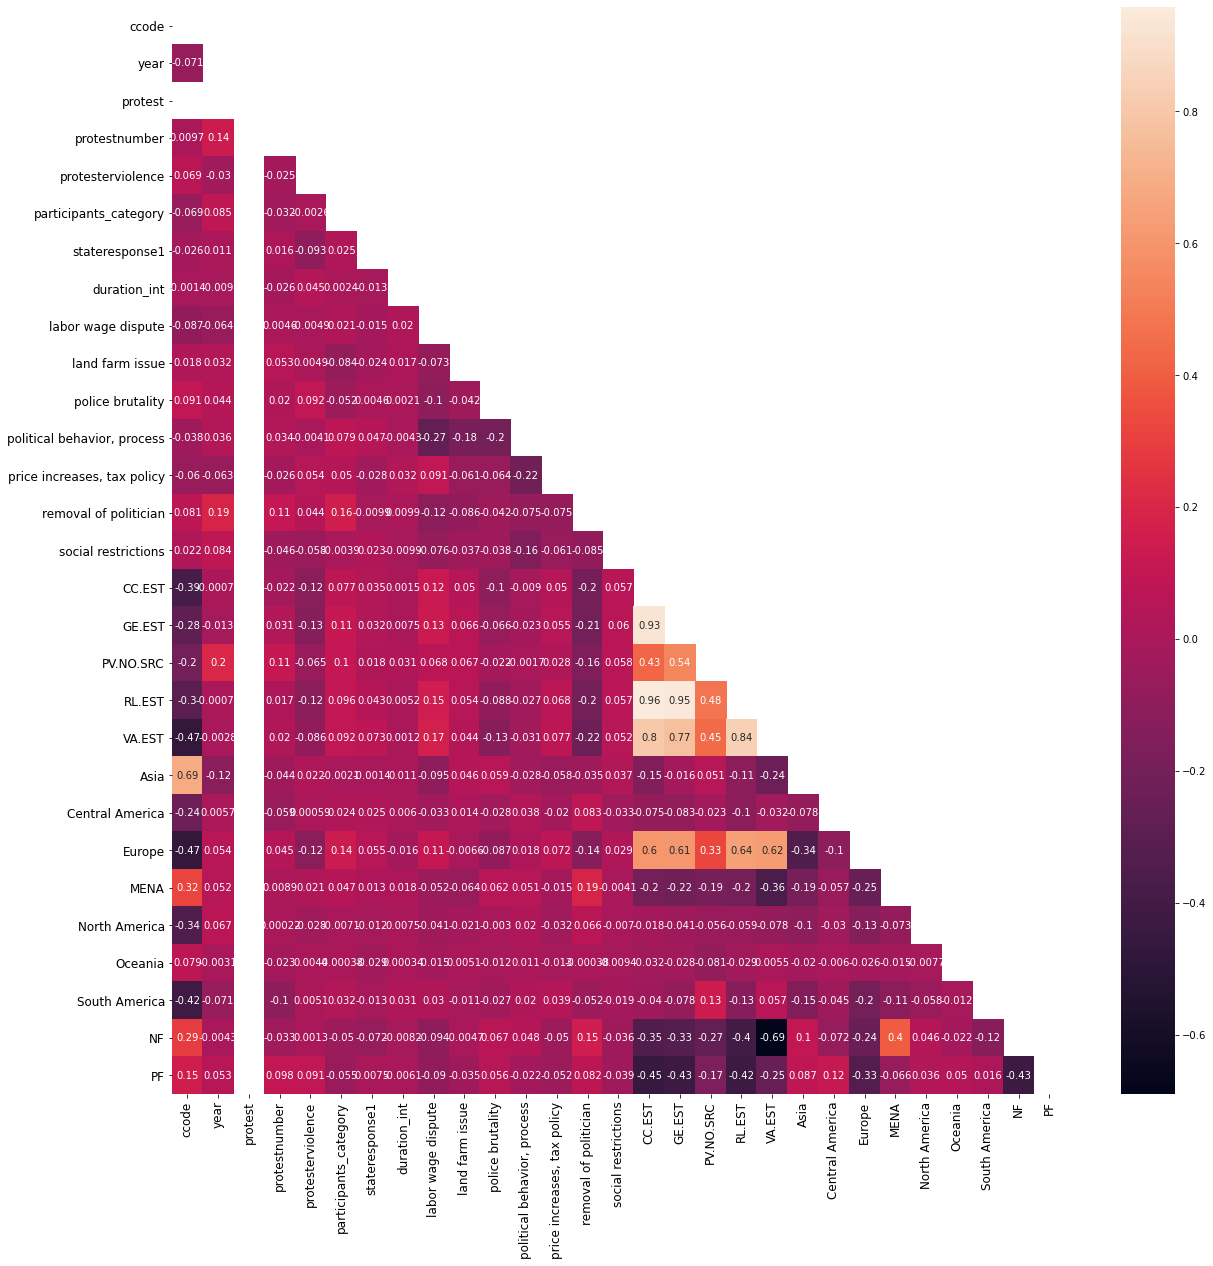

In [211]:
plt.figure(figsize = (20, 20))
corr = m_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

#### Features and Target

For this classification model I will attempt to built a model that can predict the stateresponse to a protest, with features including various aspects of the protest itself alongside World Governance Indicators and the Freedom in the World score. 

In [251]:
m_df.columns

Index(['country_name', 'ccode', 'year', 'protest', 'protestnumber',
       'protesterviolence', 'participants_category', 'stateresponse1',
       'start_date', 'end_date', 'duration', 'duration_int',
       'labor wage dispute', 'land farm issue', 'police brutality',
       'political behavior, process', 'price increases, tax policy',
       'removal of politician', 'social restrictions', 'CC.EST', 'GE.EST',
       'PV.NO.SRC', 'RL.EST', 'VA.EST', 'Asia', 'Central America', 'Europe',
       'MENA', 'North America', 'Oceania', 'South America', 'NF', 'PF'],
      dtype='object')

In [253]:
features = m_df.drop(columns=['stateresponse1', 'country_name', 'start_date', 'end_date', 'duration', 'ccode',
                             'country_name', 'protest']).columns
X = m_df[features]
X.to_csv('../streamlit/data/streamlit_multiclass_data.csv', index=False)
y = m_df['stateresponse1']

In [254]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=48, stratify=y)

#transforming data in preparation for KNN model
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [255]:
def model_metrics(some_lr, scaled=False):

    if scaled:
        train_r2 = some_lr.score(X_train_sc, y_train)
        test_r2 = some_lr.score(X_test_sc, y_test)
    else:

        train_r2 = some_lr.score(X_train, y_train)
        test_r2 = some_lr.score(X_test, y_test)
    preds = some_lr.predict(X)
    cvs = cross_val_score(some_lr, X, y, cv=5).mean()
    f1 = f1_score(y, preds, average='weighted')
    recall = recall_score(y, preds, average='weighted')
    precision = precision_score(y, preds, average='weighted', zero_division=0)
    

    final_dict={'Train R2 Score': train_r2,
                'Test R2 Score' : test_r2,
               'cross_val_score': cvs,
               'f1_score': f1,
               'precision': precision,
               'recall': recall}
    print(classification_report(y, preds, zero_division=0))
    return final_dict

#### KNeighborsClassifier

For my first model I chose to build a KNeighborsClassifier model. As such, I have scaled my data. I began by gridsearching over various hyperparameters. Based on the results of the gridsearch, I chose the following hyperparameters beyond the default settings:
* n_neighbors=23
* p=1,

This produced a well fit model, with both training and testing accuracy scores falling around 66%. While this isn't a particularly strong model, it does outperform my baseline model by about 15%. 


In [256]:
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [257]:
knn_pipe_params = {
    'ss__with_mean' : [True,False],
    'ss__with_std' : [True,False],
    'knn__p' : [1,2,3, 4],
    'knn__weights' : ['uniform', 'distance'],
    'knn__n_neighbors': range(1,29,2),
    'knn__metric': ['minkowski', 'manhattan']
}



In [258]:
# knn_pipe_gridsearch = GridSearchCV(knn_pipe, # What is the model we want to fit?
#                                  knn_pipe_params, # What is the dictionary of hyperparameters?
#                                  cv=5, # What number of folds in CV will we use?
#                                  verbose=1)

In [259]:
# Fitting this Gridsearch takes a considerable amount of time. Uncomment it to run. 

# knn_pipe_gridsearch.fit(X_train, y_train);

In [260]:
# knn_pipe_gridsearch.best_score_

In [261]:
# knn_pipe_gridsearch.best_estimator_

In [262]:
# knn_pipe_gridsearch.score(X_test, y_test)

In [263]:
knn = KNeighborsClassifier(n_neighbors=23, p=1, weights='uniform')
knn.fit(X_train_sc, y_train)
model_metrics(knn, True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       499
           1       0.33      0.00      0.00       572
           2       0.00      0.00      0.00        98
           3       0.60      0.46      0.52      2365
           4       0.63      0.92      0.75      4445
           5       0.00      0.00      0.00       115
           6       0.00      0.00      0.00       232
           7       0.00      0.00      0.00        12

    accuracy                           0.62      8338
   macro avg       0.20      0.17      0.16      8338
weighted avg       0.53      0.62      0.55      8338



{'Train R2 Score': 0.6795042643923241,
 'Test R2 Score': 0.6630695443645084,
 'cross_val_score': 0.5091115589831674,
 'f1_score': 0.5461670133552017,
 'precision': 0.5278442378283376,
 'recall': 0.6223314943631566}

#### Decision Tree Classifier

For my second model, I tried a Decision Tree Classifier. I again performed a gridsearch to select the hyperparameters for this model. Based on the output of this gridsearch, and some slight tweaking of the model, I selected the following hyperparameter settings outside of the defaults:

* ccp_alpha=0.0012
* min_samples_leaf=3
* min_samples_split=3

This model was also fairly well fit, with training and testing accuracy hovering around 68%. As such, this is a slightly stronger model than the KNN model. 

In [264]:
tree_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 1, 2],
    'min_samples_split':[2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 2, 4],
    'max_leaf_nodes': [None, 2, 3],
    'ccp_alpha': [0.0, .01, .001, .0001]
}



In [265]:
tree_gridsearch = GridSearchCV(DecisionTreeClassifier(), 
                              tree_params, 
                              cv=5, 
                              verbose=1)

In [266]:
#Uncomment the line below to run this gridsearch fit. Fitting may take several minutes. 

# tree_gridsearch.fit(X_train, y_train)

In [267]:
# uncomment the line below after fitting the tree model

# tree_gridsearch.best_score_

In [268]:
# uncomment the line below after fitting the tree model

# tree_gridsearch.best_params_

In [269]:
tree = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0012, min_samples_leaf=3, min_samples_split=3)
tree.fit(X_train, y_train)
model_metrics(tree)

              precision    recall  f1-score   support

           0       0.89      0.08      0.15       499
           1       1.00      0.07      0.12       572
           2       0.00      0.00      0.00        98
           3       0.65      0.62      0.63      2365
           4       0.70      0.94      0.80      4445
           5       0.00      0.00      0.00       115
           6       0.00      0.00      0.00       232
           7       0.00      0.00      0.00        12

    accuracy                           0.69      8338
   macro avg       0.40      0.21      0.21      8338
weighted avg       0.68      0.69      0.62      8338



{'Train R2 Score': 0.6872334754797441,
 'Test R2 Score': 0.6654676258992805,
 'cross_val_score': 0.505500914205648,
 'f1_score': 0.6230697791510669,
 'precision': 0.6765616330607884,
 'recall': 0.6850563684336771}

<Figure size 1440x1440 with 0 Axes>

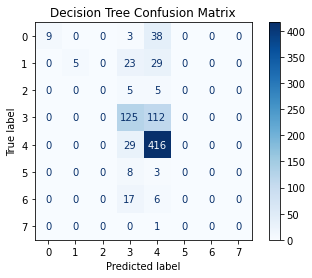

In [270]:
plt.figure(figsize=(20, 20))
plot_confusion_matrix(tree, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Decision Tree Confusion Matrix');

#### Bagging Model (Bootstrap Aggregating)

Even after gridsearching and setting hyperparameters, this bagging model underperformed my baseline model. 

In [272]:
bag_params = {
    'max_samples': [1, 2, 3, 4, 5, 6],
    'max_features': [5, 6, 7, 8, 9],
    'n_estimators': [23, 25, 27, 29, 31], 
    'oob_score': [True, False]

}



In [273]:
bag_gridsearch = GridSearchCV(BaggingClassifier(), # What is the model we want to fit?
                              bag_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1)

In [274]:
# uncomment the line below to fit the bagging model gridsearch. This operation may take several minutes. 

# bag_gridsearch.fit(X_train_sc,y_train)

In [275]:
# uncomment the line below after fitting the bag_gridsearch in the cell above. 

# bag_gridsearch.best_score_

In [276]:
# uncomment the line below after fitting the bag_gridsearch in the cell above. 

# bag_gridsearch.best_params_

In [277]:
bag = BaggingClassifier(random_state=48, max_features=6, max_samples=6, n_estimators=25, oob_score=True)
bag.fit(X_train, y_train)
model_metrics(bag)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       499
           1       0.00      0.00      0.00       572
           2       0.00      0.00      0.00        98
           3       0.57      0.01      0.01      2365
           4       0.53      1.00      0.70      4445
           5       0.00      0.00      0.00       115
           6       0.00      0.00      0.00       232
           7       0.00      0.00      0.00        12

    accuracy                           0.53      8338
   macro avg       0.14      0.13      0.09      8338
weighted avg       0.45      0.53      0.38      8338



{'Train R2 Score': 0.5345149253731343,
 'Test R2 Score': 0.5359712230215827,
 'cross_val_score': 0.535859806455975,
 'f1_score': 0.37531239066656874,
 'precision': 0.4456967218242233,
 'recall': 0.534660590069561}

### SVC

This SVC model is well fit, but underperforms the baseline model. 

In [278]:
svc = SVC(random_state=48, C=.001)
svc.fit(X_train, y_train)
model_metrics(svc, True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       499
           1       0.00      0.00      0.00       572
           2       0.00      0.00      0.00        98
           3       0.00      0.00      0.00      2365
           4       0.53      1.00      0.70      4445
           5       0.00      0.00      0.00       115
           6       0.00      0.00      0.00       232
           7       0.00      0.00      0.00        12

    accuracy                           0.53      8338
   macro avg       0.07      0.12      0.09      8338
weighted avg       0.28      0.53      0.37      8338



{'Train R2 Score': 0.5330490405117271,
 'Test R2 Score': 0.5335731414868106,
 'cross_val_score': 0.5331015091945639,
 'f1_score': 0.37074802532079343,
 'precision': 0.28419717004531675,
 'recall': 0.5331014631806189}

#### Stacking
I experimented with stacking my two models that outperformed the baseline model (knn and decision tree), and found that this slightly improved the accuracy of the model. As such, this is the model I will deploy. 

In [279]:
# knn = KNeighborsClassifier(n_neighbors=23, p=1, weights='uniform')
# tree = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0012, min_samples_leaf=3, min_samples_split=3)

In [299]:
estimators = [('knn', KNeighborsClassifier(n_neighbors=23, p=1, weights='uniform')),
              ('tree', DecisionTreeClassifier(random_state=42, ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3))]

In [300]:
stacks = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=7)

In [301]:
stacks.fit(X_train, y_train)
model_metrics(stacks)

              precision    recall  f1-score   support

           0       0.59      0.10      0.17       499
           1       0.64      0.25      0.36       572
           2       0.88      0.07      0.13        98
           3       0.65      0.69      0.67      2365
           4       0.74      0.91      0.82      4445
           5       0.75      0.03      0.05       115
           6       0.56      0.16      0.25       232
           7       0.00      0.00      0.00        12

    accuracy                           0.71      8338
   macro avg       0.60      0.28      0.31      8338
weighted avg       0.69      0.71      0.67      8338



{'Train R2 Score': 0.7102878464818764,
 'Test R2 Score': 0.684652278177458,
 'cross_val_score': 0.5023713242962918,
 'f1_score': 0.6681984256404164,
 'precision': 0.6942143967256518,
 'recall': 0.7077236747421444}

<Figure size 1440x1440 with 0 Axes>

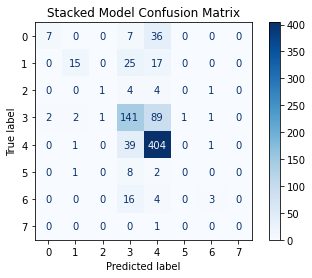

In [305]:
plt.figure(figsize=(20, 20))
plot_confusion_matrix(stacks, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Stacked Model Confusion Matrix');

In [304]:
# saving this model

# joblib.dump(stacks, '../streamlit/models/multiclass.pkl')

['../streamlit/models/multiclass.pkl']

### <a name="binary"></a>  Binary Classification

#### Purpose: To predict if protesters will engage in violence. 

I had initially considered created a binary classification model to predict if a state would respond with violence to a protest. However, the classes were simply unbalanced for such modeling to be practical. The state ignores 53%, and uses crowd dispersal in 28%. 95% of protests conclude without state violence. 


[Jump to the top of the page](#top3)

In [231]:
b_df = pd.read_csv('../data/transformed/mm_wgi_fiw.csv')
b_df['stateresponse1'].value_counts(normalize=True)

ignore             0.533101
crowd dispersal    0.283641
arrests            0.068602
accomodation       0.059846
shootings          0.027824
killings           0.013792
beatings           0.011753
unknown            0.001439
Name: stateresponse1, dtype: float64

In [232]:
b_df['protesterviolence'].value_counts(normalize=True)

0    0.741065
1    0.258935
Name: protesterviolence, dtype: float64

In [233]:
b_df = mm.categorical_to_encode(b_df,[], ['fiw_status', 'stateresponse1'])
b_df.head(3)

,country_name,ccode,year,region,protest,protestnumber,protesterviolence,participants_category,start_date,end_date,...,VA.EST,NF,PF,arrests,beatings,crowd dispersal,ignore,killings,shootings,unknown
0,Canada,20,2006,North America,1,1,1,3,2006-02-21,2006-08-17,...,1.415595,0,0,0,0,1,0,0,0,0
1,Canada,20,2007,North America,1,1,0,5,2007-06-29,2007-06-29,...,1.384672,0,0,0,0,0,1,0,0,0
2,Canada,20,2008,North America,1,1,1,3,2008-08-10,2008-08-10,...,1.407529,0,0,0,0,1,0,0,0,0


In [234]:
features = b_df.drop(columns=['country_name', 'ccode', 'protest', 'duration', 'region', 'start_date', 'end_date', 'protesterviolence']).columns
X = b_df[features]
y = b_df['protesterviolence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=48, stratify=y)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Baseline Model

Based on the majority class, this model will be accurate 74% of the time. 

In [235]:
y.value_counts(normalize=True)

0    0.741065
1    0.258935
Name: protesterviolence, dtype: float64

In [236]:
logreg = LogisticRegression(max_iter=20_000, random_state=48)
logreg.fit(X_train, y_train)
model_metrics(logreg)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6179
           1       0.62      0.66      0.64      2159

    accuracy                           0.81      8338
   macro avg       0.75      0.76      0.76      8338
weighted avg       0.81      0.81      0.81      8338



{'Train R2 Score': 0.8074360341151386,
 'Test R2 Score': 0.8093525179856115,
 'cross_val_score': 0.7853147356140283,
 'f1_score': 0.809751839378354,
 'precision': 0.8124907770565422,
 'recall': 0.8076277284720557}

In examining the coefficients from this model, we can see that protester violence is most likely to occure alongside a violent response from the state. 
The next most important features are whether or not the protest is in regards to a land farm issue. 

In [237]:
coef = list(logreg.coef_)
features = list(X.columns)
protesterviolence_coef = pd.DataFrame(zip(features, coef[0]), columns=['Feature', 'Coefficient'],index=features).drop(columns='Feature').sort_values(by='Coefficient', ascending=False)
protesterviolence_coef

,Coefficient
killings,2.297170
crowd dispersal,1.949463
shootings,1.939124
beatings,1.440511
arrests,1.133560
police brutality,0.479940
"price increases, tax policy",0.434838
land farm issue,0.422353
VA.EST,0.265835
labor wage dispute,0.238493


<Figure size 1440x1440 with 0 Axes>

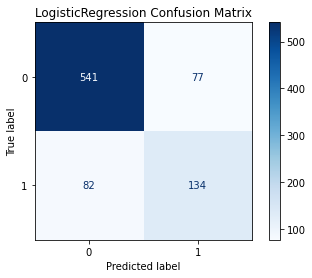

In [238]:
plt.figure(figsize=(20, 20))
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', values_format='d')
plt.title('LogisticRegression Confusion Matrix');

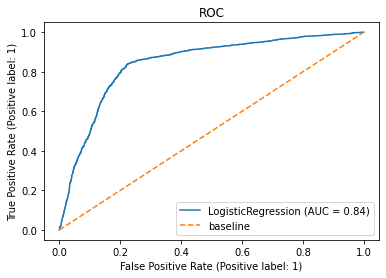

In [243]:
#ROC plot code is from General Assembly lesson 4.05.
plot_roc_curve(logreg, X, y)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

### KNN

This model is well fit and outperforms the baseline model, but has slightly lower precision and recall scores than the Decision Trees model. 


In [182]:
knn2 = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
model_metrics(knn, True)

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      6179
           1       0.58      0.21      0.30      2159

    accuracy                           0.76      8338
   macro avg       0.68      0.58      0.58      8338
weighted avg       0.72      0.76      0.71      8338



{'Train R2 Score': 0.8272921108742004,
 'Test R2 Score': 0.8201438848920863,
 'cross_val_score': 0.7407041613260082,
 'f1_score': 0.7100936196222255,
 'precision': 0.7235247303538399,
 'recall': 0.7558167426241305}

### DecisionTree

This model is well fit, outperforms the baseline model, and has f1, precision, and recall scores on par with the LogisticRegression model. 

In [187]:
trees = DecisionTreeClassifier(random_state=48, ccp_alpha=.0015)
trees.fit(X_train, y_train)
model_metrics(trees)


              precision    recall  f1-score   support

           0       0.88      0.86      0.87      6179
           1       0.62      0.66      0.64      2159

    accuracy                           0.81      8338
   macro avg       0.75      0.76      0.76      8338
weighted avg       0.81      0.81      0.81      8338



{'Train R2 Score': 0.80863539445629,
 'Test R2 Score': 0.8057553956834532,
 'cross_val_score': 0.7869949751056982,
 'f1_score': 0.8102844036842395,
 'precision': 0.8127327852212684,
 'recall': 0.8083473254977213}